# HOMEWORK 4 - APPLIED ML

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import networkx as nx
import itertools
import sys

## 1. Propensity score matching

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [4]:
#loading data
lalonde_df = pd.read_csv('lalonde.csv').set_index('id')
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1.1. A naive analysis

In [5]:
treated = lalonde_df.loc[lalonde_df['treat'] == 1]
not_treated = lalonde_df.loc[lalonde_df['treat'] == 0]

In [6]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [7]:
not_treated['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

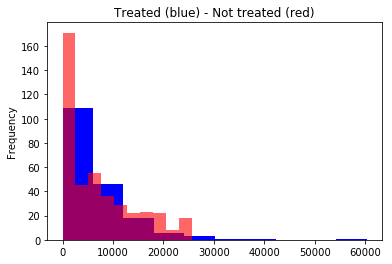

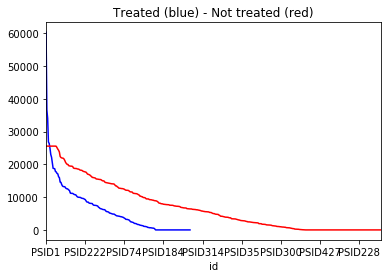

In [8]:
treated['re78'].plot(kind='hist',  color='blue', title='Treated (blue) - Not treated (red)')
not_treated['re78'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

treated['re78'].sort_values(ascending=False).plot(color='blue', title='Treated (blue) - Not treated (red)')
not_treated['re78'].sort_values(ascending=False).plot(color='red')
plt.show()

Here a naive "researcher" might conclude that the treatment doesn't work. As the average income of the not treated group is higher than the the one form the treated group. But he/she could also conclude that if you are part of the few *lucky* ones in the treated group, you will have a much higher income than the people which are not getting the training.

### 1.2. A closer look at the data

We will now compare the distribution of real income values but this time for each year, ages and education level. Comparing the 1/0 values of the race, marriage and treatment does not make much sens.

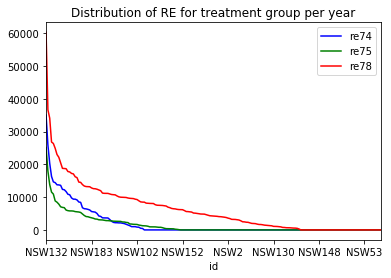

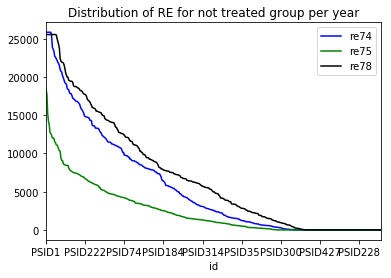

In [9]:
treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for treatment group per year', legend=True)
treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
treated['re78'].sort_values(ascending=False).plot(color='red', legend=True)
plt.show()

not_treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for not treated group per year', legend=True)
not_treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
not_treated['re78'].sort_values(ascending=False).plot(color='black', legend=True)
plt.show()

It would seem now (for the less naïve researcher) that the treatment actually works as we see the number of unemployed person (with real income = 0.0) decrease much faster in the treated group as in the other. To confirm this intuition let's print the amount of unemployed person in both groups.

In [10]:
print('Unemployed person in Treated group per year:\n',(treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))
print('Unemployed person in Not-treated group per year:\n',(not_treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))

Unemployed person in Treated group per year:
 re74    131
re75    111
re78     45
dtype: int64
Unemployed person in Not-treated group per year:
 re74    112
re75    134
re78     98
dtype: int64


The education level is very similar in both groups:

In [11]:
treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [12]:
not_treated['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

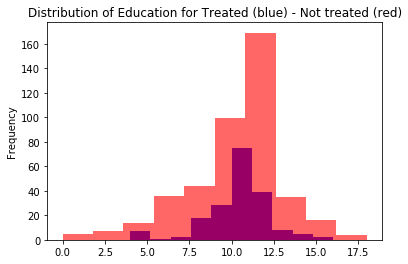

In [13]:
treated['educ'].plot(kind='hist', color='blue', title='Distribution of Education for Treated (blue) - Not treated (red)')
not_treated['educ'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

People in the treatment group seem to be a little bit younger, but this could be explained the fact that younger people might be more willing to do training programs:

In [14]:
treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [15]:
not_treated['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

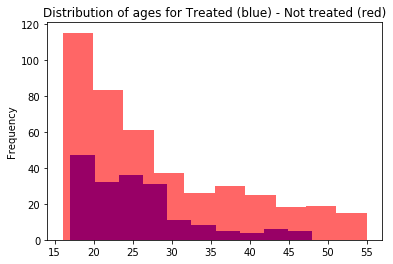

In [16]:
treated['age'].plot(kind='hist', color='blue', title='Distribution of ages for Treated (blue) - Not treated (red)')
not_treated['age'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

In average people in the training programs tends to have a degree less often than in the other group:

In [17]:
treated['nodegree'].describe()

count    185.000000
mean       0.708108
std        0.455867
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

In [18]:
not_treated['nodegree'].describe()

count    429.000000
mean       0.596737
std        0.491126
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

### 1.3. A propensity score model

In [19]:
logistic = linear_model.LogisticRegression()
X = lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']]
y = lalonde_df['treat']
#training logistic model
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here is the propensity score (probability of belonging to the class 0 or 1)

In [20]:
prop_score = logistic.predict_proba(X)
prop_score

array([[ 0.54192649,  0.45807351],
       [ 0.84801994,  0.15198006],
       [ 0.24903448,  0.75096552],
       ..., 
       [ 0.89944167,  0.10055833],
       [ 0.44954653,  0.55045347],
       [ 0.79880343,  0.20119657]])

Now we will add it to te dataframe to keep each score with its matching data point.

In [21]:
lalonde_df['prop_score_0'] = prop_score[:, 0]
lalonde_df['prop_score_1'] = prop_score[:, 1]

In [22]:
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score_0,prop_score_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590


### 1.4. Balancing the dataset via matching

We will use a simple function that calculate te distance between two points to match the propensity scores.

In [23]:
treated = lalonde_df.loc[lalonde_df['treat'] == 1]
not_treated = lalonde_df.loc[lalonde_df['treat'] == 0]

In [24]:
#Compute distance between two values
def compute_diff(val_1, val_2):
    return np.sqrt(np.power(val_1 - val_2, 2))

#Create a matched list of Treated-Controled based on propensity score of beeing in the treated group
def match_propensity(treated, control):
    matches_ind = []
    matches_score = []
    #list of already matched control point, to not have duplicates.
    matched = []
    for t_idx in treated.index:
        temp_min = sys.maxsize
        temp_indx = 'NAN'
        t_row = treated.loc[t_idx]
        for c_idx in control.index:
            c_row = control.loc[c_idx]
            diff = compute_diff(t_row['prop_score_1'], c_row['prop_score_1'])
            if diff < temp_min and c_idx not in matched:
                temp_min = diff 
                temp_indx = c_idx
        matches_ind.append([t_idx, temp_indx])
        matches_score.append([t_row['prop_score_1'], control.loc[temp_indx]['prop_score_1']])
        matched.append(temp_indx)
    return np.array(matches_ind), np.array(matches_score)

In [25]:
m_ind, m_scores = match_propensity(treated, not_treated)

In [26]:
m_scores[:10]

array([[ 0.45807351,  0.46895593],
       [ 0.15198006,  0.15121151],
       [ 0.75096552,  0.7517876 ],
       [ 0.67401978,  0.67436073],
       [ 0.67059037,  0.67315518],
       [ 0.71125444,  0.71129477],
       [ 0.64961649,  0.6490786 ],
       [ 0.66043351,  0.66108822],
       [ 0.58382034,  0.58726769],
       [ 0.08673513,  0.0868916 ]])

The propensity scores matched seem really similar, so we will keep them. Now, let's try to analyse only the matched pairs:

In [27]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [28]:
not_treated.loc[m_ind[:, 1]]['re78'].describe()

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64

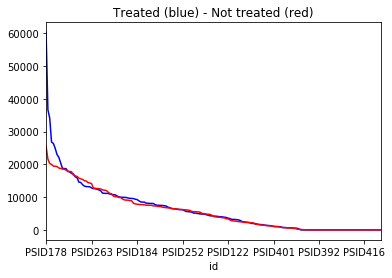

In [29]:
treated['re78'].sort_values(ascending=False).plot(color='blue', title='Treated (blue) - Not treated (red)')
not_treated.loc[m_ind[:, 1]]['re78'].sort_values(ascending=False).plot(color='red')
plt.show()

We can see now that, except for the particularly high incomes of a few treated people, the distribution of real income in 78 matches very well. And we can see that actually with those matched pairs, both group have very similar distribution of real income for every year:

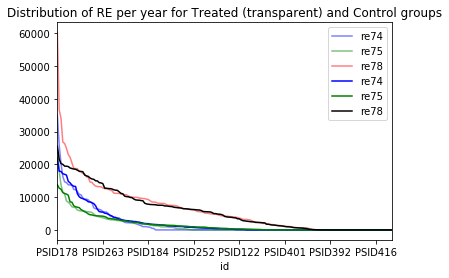

In [30]:
treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE per year for Treated (transparent) and Control groups', legend=True, alpha=0.5)
treated['re75'].sort_values(ascending=False).plot(color='green', legend=True, alpha=0.5)
treated['re78'].sort_values(ascending=False).plot(color='red', legend=True, alpha=0.5)
not_treated['re74'].loc[m_ind[:, 1]].sort_values(ascending=False).plot(color='blue', legend=True)
not_treated['re75'].loc[m_ind[:, 1]].sort_values(ascending=False).plot(color='green', legend=True)
not_treated['re78'].loc[m_ind[:, 1]].sort_values(ascending=False).plot(color='black', legend=True)
#axes = plt.gca()
#axes.set_ylim([0,60000])
plt.show()

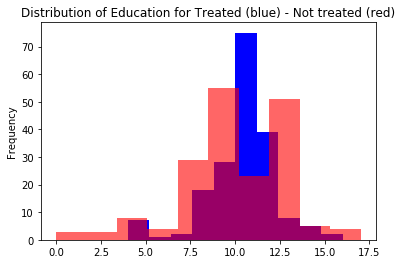

In [31]:
treated['educ'].plot(kind='hist', color='blue', title='Distribution of Education for Treated (blue) - Not treated (red)')
not_treated['educ'].loc[m_ind[:, 1]].plot(kind='hist', color='red', alpha=0.6)
plt.show()

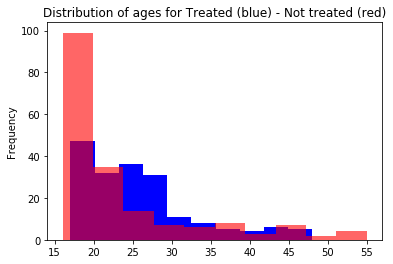

In [32]:
treated['age'].plot(kind='hist', color='blue', title='Distribution of ages for Treated (blue) - Not treated (red)')
not_treated['age'].loc[m_ind[:, 1]].plot(kind='hist', color='red', alpha=0.6)
plt.show()

This time the amount of people without a degree is much more similar

In [148]:
treated['nodegree'].describe()

count    185.000000
mean       0.708108
std        0.455867
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

In [149]:
not_treated['nodegree'].loc[m_ind[:, 1]].describe()

count    185.000000
mean       0.675676
std        0.469392
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

From here we can draw these conclusions:
- The real income distribution of people with similar posterior attributes, is very close and does not seem to depend on the fact that one was treated or not. So the difference of income and unemployed people between each year could well be the cause of economic fluctuations.
- The distribution of education time seem to be a gaussian distribution of mean around 10 for both groups.
- There seem to be much more *very* young people (15-20 years old) that did not get the treatment.
- The propotion of person without a degree is very similar in both groups with the matched pair approach, although it is still higher in the treatment group, which seems to mean that people without diploma are more willing to take a training.

### 1.5. Balancing the groups further

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)). [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from random import shuffle
from sklearn.metrics import confusion_matrix

### 1. Load the data and we separate targets and features: 

In [11]:
newsgroups_train = fetch_20newsgroups(subset="all")
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)

X = vectorizer.fit_transform(newsgroups_train.data)
y = newsgroups_train.target

### 2. Split the set to 0.9 train data and 0.1 test data

In [12]:
n = len(y)
indices = list(range(n))
shuffle(indices)

test_len = round(0.1*n)
train_len = n - test_len

X_test = X[indices[0:test_len]]
y_test = y[indices[0:test_len]]

X_train = X[indices[test_len:n]]
y_train = y[indices[test_len:n]]

### 3. Cross validation with 0.1 validation data and 0.9 train data (from the remaining dataset) 

- The estimators are in range: 50 - 300 with step size 50 
- The depths are in range 50 - 30 with step size 50 

In order to visualise the results of the grid search we keep track of the different combinations of: 

- n_estimators
- max_depth 
- mean accuracy over 10-fold cross validation 

In [ ]:
heatmap = np.zeros((6,6))

for n_estimators in range(50, 301, 50): 
    for max_depth in range(50, 301, 50): 
        print("n_estimators={}, max_depth={}".format(n_estimators/50 - 1, max_depth/50 - 1))
        random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=2)
        scores = cross_val_score(random_forest, X_train, y_train, cv=10, n_jobs=4)
        heatmap[int(n_estimators/50 - 1), int(max_depth/50 - 1)] = np.mean(scores)

n_estimators=0.0, max_depth=0.0
n_estimators=0.0, max_depth=1.0
n_estimators=0.0, max_depth=2.0
n_estimators=0.0, max_depth=3.0
n_estimators=0.0, max_depth=4.0


Here we show the heatmap for the accuracies obtained with different parameters. The vertical axis is the number of estimators, the horizontal axis is the max depth. 

In [5]:
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.scatter3D(x,y,z)
#plt.show()

plt.imshow(heatmap, cmap='hot')
plt.show()

The best parameters to chose in this case are n_estimators= and max_depth= . We can see that the accuracy is increasing when these parameters are increased but the increased computing time is not worth the very small accuracy gain. 

In [40]:
random_forest = RandomForestClassifier(n_estimators=300, max_depth=200)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=200, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
y_pred = random_forest.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

0.87444739168877095

In [75]:
for r in range(1,100):
    print(vectorizer.get_feature_names()[indices[-r]])
    print(len(np.nonzero(X[:, indices[-r]])[0]))

windows
790
sale
491
dod
388
car
573
bike
277
space
624
encryption
278
clipper
337
hockey
250
god
824
israeli
215
cars
266
israel
287
gun
370
baseball
282
mac
391
graphics
422
christians
339
apple
370
team
497
rutgers
323
article
5272
nhl
187
key
556
chip
492
window
384
com
4790
game
554
christian
486
guns
244
host
4840
people
2547
motif
140
government
788
posting
5086
players
286
athos
148
nntp
4777
offer
352
bikes
109
orbit
141
circuit
120
shipping
207
thanks
1731
bible
325
ride
177
riding
131
atheists
184
jesus
364
card
572
escrow
147
university
4437
file
553
motorcycle
114
christ
287
distribution
2633
nasa
420
season
284
controller
185
x11r5
104
church
258
moon
150
drive
688
playoffs
119
use
2200
disease
135
quadra
95
crypto
141
arab
136
mit
375
games
398
forsale
86
doctor
140
pc
461
tapped
89
waco
159
know
3291
pitching
89
does
2656
play
505
just
3492
shuttle
96
algorithm
201
playoff
108
ca
1802
prb
78
dos
390
pgp
135
expo
90
firearms
118
don
3349
clinton
335
clh
97
widget
87
win
